In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
import tensorflow as tf

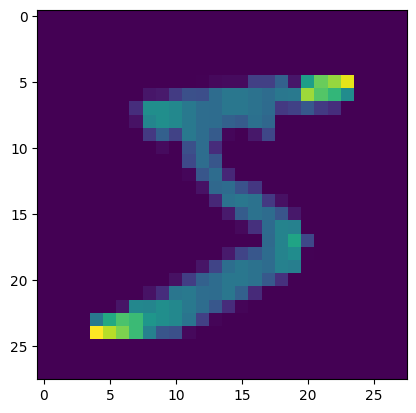

In [ ]:
#Normalized data (scale)

x_train = tf.keras.utils.normalize(x_train, axis = 1) 
x_test = tf.keras.utils.normalize(x_test, axis = 1) 

import matplotlib.pyplot as plt
plt.imshow(x_train[0].reshape(28, 28, 1))

In [ ]:
x_test = x_test.reshape(10000, 28*28)

In [ ]:
x_train = x_train.reshape(60000, 28*28)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_train.shape

(60000, 10, 10)

In [ ]:
%matplotlib inline
#from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor) 

x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor) 

In [ ]:
x_train.shape

(60000, 784)

Lee used a neural network with one hiddedn layer. Lee used a rectified linear unit for the one hidden layer.  Sigmoid was use for the output layer. There are five thousand nodes. For optimization Lee used mini-batch Stochastic Gradient Descent with Dropout. The learning rate was set to 1.5 initially and the mini batch number was 32 for labeled data and 256 for unlabeled data. The parameters were determined by using the validation set.


1.- Train model on a batch of labeled data <br>
2.- Use the trained model to predict labels on a batch of unlabeled data <br>
3.- Use the predicted labels to calculate the loss on unlabeled data <br>
4.- Combine labeled loss with unlabeled (by adding alpha weight to the loss of unlabeled data) loss and backpropagate <br>


In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.reshape(10000, 28*28)
x_train = x_train.reshape(60000, 28*28)

UNLABELED_BS = 256
TRAIN_BS = 32
TEST_BS = 1024

num_train_samples = 1000
samples_per_class = int(num_train_samples/9)

from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
x_train_t = normalizer.fit_transform(x_test[:1000])
x_unlabeled = normalizer.transform(x_train)
x_test_t = normalizer.transform(x_test[:5000])


x_train_ = torch.from_numpy(x_train_t).type(torch.FloatTensor)
y_train_ = torch.from_numpy(y_test[:1000]).type(torch.LongTensor) 

x_test_ = torch.from_numpy(x_test_t).type(torch.FloatTensor)
y_test_ = torch.from_numpy(y_test[:5000]).type(torch.LongTensor) 

print(len(x_test_), len(y_test_))
train = torch.utils.data.TensorDataset(x_train_, y_train_)
test = torch.utils.data.TensorDataset(x_test_, y_test_)

train_loader = torch.utils.data.DataLoader(train, batch_size = TRAIN_BS, shuffle = True, num_workers = 8)

unlabeled_train = torch.from_numpy(x_unlabeled).type(torch.FloatTensor)

unlabeled = torch.utils.data.TensorDataset(unlabeled_train)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled, batch_size = UNLABELED_BS, shuffle = True, num_workers = 8)

test_loader = torch.utils.data.DataLoader(test, batch_size = TEST_BS, shuffle = True, num_workers = 8)




5000 5000


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

"""
Set of two convolutional layers with maxpool and droput method 
applied relu to each Conv2 layer and softmax as the last output layer

"""
class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
            self.conv2 = nn.Conv2d(20, 40, kernel_size=5)
            self.conv2_drop = nn.Dropout2d()
            self.fc1 = nn.Linear(640, 150)
            self.fc2 = nn.Linear(150, 10)
            self.log_softmax = nn.LogSoftmax(dim = 1)

        def forward(self, x):
            x = x.view(-1,1,28,28)
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
            x = x.view(-1, 640)
            x = F.relu(self.fc1(x))
            x = F.dropout(x, training=self.training)
            x = F.relu(self.fc2(x))
            x = self.log_softmax(x)
            return x
        
net = Net()#.cuda()

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0 
    loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data #.cuda()
            output = model(data)
            predicted = torch.max(output,1)[1]
            correct += (predicted == labels).sum()
            loss += F.nll_loss(output, labels).item()

    return (float(correct)/len(test)) *100, (loss/len(test_loader))

In [ ]:
from tqdm import tqdm_notebook

"""
This pretty much trains the model with the labeled data per batch 
at each batch get the input and hold on the loss value
add the losses to the overall loss at every bacth
"""

def train_supervised(model, train_loader, test_loader):
    optimizer = torch.optim.SGD( model.parameters(), lr = 0.1)
    EPOCHS = 100
    model.train()
    for epoch in tqdm_notebook(range(EPOCHS)):
        correct = 0
        running_loss = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch, y_batch #.cuda()
            
            output = model(X_batch)
            labeled_loss = F.nll_loss(output, y_batch)
                       
            optimizer.zero_grad()
            labeled_loss.backward()
            optimizer.step()
            running_loss += labeled_loss.item()
        
        if epoch %10 == 0:
            test_acc, test_loss = evaluate(model, test_loader)
            print('Epoch: {} : Train Loss : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, running_loss/(10 * len(train)), test_acc, test_loss))
            model.train()
    

In [ ]:
train_supervised(net, train_loader, test_loader)

<ipython-input-50-81304e7db4b7>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(EPOCHS)):


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 : Train Loss : 0.00737 | Test Acc : 10.60000 | Test Loss : 2.302 
Epoch: 10 : Train Loss : 0.00735 | Test Acc : 20.26000 | Test Loss : 2.298 
Epoch: 20 : Train Loss : 0.00507 | Test Acc : 26.32000 | Test Loss : 2.012 
Epoch: 30 : Train Loss : 0.00160 | Test Acc : 84.84000 | Test Loss : 0.446 
Epoch: 40 : Train Loss : 0.00105 | Test Acc : 90.20000 | Test Loss : 0.308 
Epoch: 50 : Train Loss : 0.00071 | Test Acc : 93.08000 | Test Loss : 0.231 
Epoch: 60 : Train Loss : 0.00060 | Test Acc : 92.84000 | Test Loss : 0.230 
Epoch: 70 : Train Loss : 0.00046 | Test Acc : 94.14000 | Test Loss : 0.198 
Epoch: 80 : Train Loss : 0.00041 | Test Acc : 94.18000 | Test Loss : 0.213 
Epoch: 90 : Train Loss : 0.00032 | Test Acc : 94.58000 | Test Loss : 0.191 


In [ ]:
T1 = 100
T2 = 700
af = 3

def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

In [ ]:
from tqdm import tqdm_notebook

acc_scores = []
unlabel = []
pseudo_label = []

alpha_log = []
test_acc_log = []
test_loss_log = []
def semisup_train(model, train_loader, unlabeled_loader, test_loader):
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    EPOCHS = 150
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 100 
    
    model.train()
    for epoch in tqdm_notebook(range(EPOCHS)):
        for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled = x_unlabeled[0] #.cuda()
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()
            
            
            """ ONLY FOR VISUALIZATION"""
            if (batch_idx < 3) and (epoch % 10 == 0):
                unlabel.append(x_unlabeled.cpu())
                pseudo_label.append(pseudo_labeled.cpu())
            """ ********************** """
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * F.nll_loss(output, pseudo_labeled)   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # For every 50 batches train one epoch on labeled data 
            if batch_idx % 50 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    X_batch = X_batch #.cuda()
                    y_batch = y_batch 
                    #.cuda()
                    output = model(X_batch)
                    labeled_loss = F.nll_loss(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
                

        test_acc, test_loss =evaluate(model, test_loader)
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, alpha_weight(step), test_acc, test_loss))
        
        """ LOGGING VALUES """
        alpha_log.append(alpha_weight(step))
        test_acc_log.append(test_acc/100)
        test_loss_log.append(test_loss)
        """ ************** """
        model.train()
 

In [ ]:
semisup_train(net, train_loader, unlabeled_loader, test_loader)

<ipython-input-56-e0ab3a72d07f>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(EPOCHS)):


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0 : Alpha Weight : 0.02500 | Test Acc : 94.78000 | Test Loss : 0.211 
Epoch: 1 : Alpha Weight : 0.05000 | Test Acc : 94.94000 | Test Loss : 0.202 
Epoch: 2 : Alpha Weight : 0.07500 | Test Acc : 95.20000 | Test Loss : 0.197 
Epoch: 3 : Alpha Weight : 0.10000 | Test Acc : 95.02000 | Test Loss : 0.199 
Epoch: 4 : Alpha Weight : 0.12500 | Test Acc : 95.10000 | Test Loss : 0.205 
Epoch: 5 : Alpha Weight : 0.15000 | Test Acc : 95.40000 | Test Loss : 0.188 
Epoch: 6 : Alpha Weight : 0.17500 | Test Acc : 95.50000 | Test Loss : 0.191 
Epoch: 7 : Alpha Weight : 0.20000 | Test Acc : 95.52000 | Test Loss : 0.190 
Epoch: 8 : Alpha Weight : 0.22500 | Test Acc : 95.66000 | Test Loss : 0.185 
Epoch: 9 : Alpha Weight : 0.25000 | Test Acc : 95.80000 | Test Loss : 0.179 
Epoch: 10 : Alpha Weight : 0.27500 | Test Acc : 95.80000 | Test Loss : 0.181 
Epoch: 11 : Alpha Weight : 0.30000 | Test Acc : 95.90000 | Test Loss : 0.177 
Epoch: 12 : Alpha Weight : 0.32500 | Test Acc : 95.82000 | Test Loss : 0.1

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [ ]:
test_acc, test_loss = evaluate(net, test_loader)
print('Test Acc : {:.5f} | Test Loss : {:.3f} '.format(test_acc, test_loss))

Test Acc : 97.34000 | Test Loss : 0.120 


In [ ]:

# Based on https://github.com/peimengsui/semi_supervised_mnist
from tqdm import tqdm_notebook

T1 = 100
T2 = 700
af = 3

def alpha_weight(step):
    if step < T1:
        return 0.0
    elif step > T2:
        return af
    else:
         return ((step-T1) / (T2-T1))*af
        

def semisup_train(model, train_loader, unlabeled_loader, test_loader):

  optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
  EPOCHS = 100
  
  # Instead of using current epoch we use a "step" variable to calculate alpha_weight
  # This helps the model converge faster
  step = 100 
  
  model.train()
  for epoch in tqdm_notebook(range(EPOCHS)):

    for batch_idx, x_unlabeled in enumerate(unlabeled_loader): 
        
      # Forward Pass to get the pseudo labels
      x_unlabeled = x_unlabeled.cuda()
      model.eval()
      output_unlabeled = model(x_unlabeled)
      _, pseudo_labeled = torch.max(output_unlabeled, 1)
      model.train()          
      
      # Now calculate the unlabeled loss using the pseudo label
      output = model(x_unlabeled)
      unlabeled_loss = alpha_weight(step) * F.nll_loss(output, pseudo_labeled)   
      
      # Backpropogate
      optimizer.zero_grad()
      unlabeled_loss.backward()
      optimizer.step()
      
      
      # For every 50 batches train one epoch on labeled data 
      if batch_idx % 50 == 0: 
        # Normal training procedure
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):

          X_batch = X_batch.cuda()
          y_batch = y_batch.cuda()
          output = model(X_batch)
          labeled_loss = F.nll_loss(output, y_batch)

          optimizer.zero_grad()
          labeled_loss.backward()
          optimizer.step()
        
        # Now we increment step by 1
        step += 1


In [ ]:
"""Lee mentions a pre-training phase by using DAE to clean noisy data"""

autoencoder = tf.keras.models.Sequential()
#autoencoder.add(tf.keras.layers.Flatten())

autoencoder.add(tf.keras.layers.Dense(10 , activation = 'relu', input_shape = (784,)))

#add 2 conv layers with 20 and 40 nodes each
autoencoder.add(tf.keras.layers.Dense(5000, activation = "relu",\
                                      activity_regularizer=tf.keras.regularizers.L1(0.0001)))

#autoencoder.add(tf.keras.layers.Dropout(0.50))
autoencoder.add(tf.keras.layers.BatchNormalization())
#output layer
autoencoder.add(tf.keras.layers.Dense(784, activation = "relu"))

#dropout layer Lee drops 50% of the layer's nodes


#tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0)/ categorical_crossentropy
autoencoder.compile(optimizer = "adam",\
              loss= 'mse', metrics =["accuracy"])#, "loss"])






call_b = autoencoder.fit(X_train_noisy, x_train, epochs= 3, batch_size=32, verbose=1, validation_data=(X_test_noisy, x_test))

#autoencoder.summary()

encoder = tf.keras.models.Sequential()
encoder.add(autoencoder.layers[0])

#encodings = encoder.predict(x_test[:3])

Epoch 1/3
1875/1875 [==============================] - 120s 64ms/step - loss: 0.0018 - accuracy: 8.3333e-05 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 2/3
1875/1875 [==============================] - 119s 63ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 3/3
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00


In [ ]:

encodings = encoder.predict(X_test_noisy[:3])
#X_test_denoised = model.predict(X_test_noisy)

1/1 [==============================] - 0s 23ms/step


In [ ]:
encodings[np.where(encodings[0].all()> 0 or encodings[0].all() <1)][0]

array([0.04385457, 0.        , 0.02807328, ..., 0.00175678, 0.06558236,
       0.        ], dtype=float32)

In [ ]:
#defining the alpha function as defined by Lee

T1 = 100 #number of epochs
T2 = 600 #number of epochs after T1
af = 3
def alpha_weight(step):
  if step < T1: return 0.0
  elif step > T2: return af
  else: return ((step-T1) / (T2-T1))*af

  

In [ ]:
t = np.arange(0,900, 100)
alpha = np.array([alpha_weight(i) for i in t])

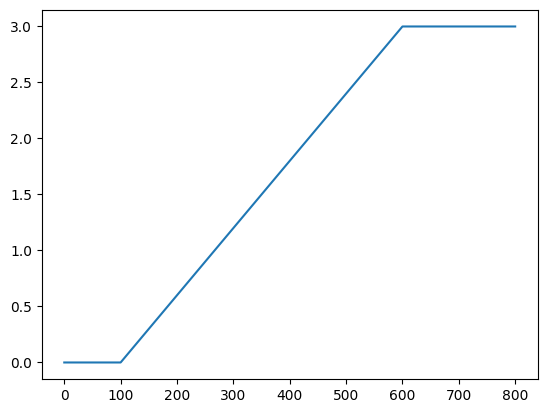

In [ ]:
plt.plot(t, alpha)
plt.show()

In [ ]:
# create sequential
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())

#add 2 conv layers with 20 and 40 nodes each
model.add(tf.keras.layers.Dense(5000, activation = "relu"))

#output layer
model.add(tf.keras.layers.Dense(10, activation = "sigmoid"))

#dropout layer Lee drops 50% of the layer's nodes
model.add(tf.keras.layers.Dropout(0.50))

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.0),\
              loss= 'categorical_crossentropy', metrics =["accuracy", tf.keras.metrics.CategoricalCrossentropy()])




In [ ]:
#most common feedforward model for deep learning


model = tf.keras.models.Sequential()

#Images are 28X28 (matrix) but we want a flat array so we us Flatten(), can also used np.reshape
model.add(tf.keras.layers.Flatten())

#activation _> what will fire the neuron?
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))

#softmax is used because of a proability distribution problem

"""The softmax function is a function that turns a vector of K real values into a vector of K real values that sum to 1.
 The input values can be positive, negative, zero, or greater than one, but the softmax transforms them into 
 values between 0 and 1,so that they can be interpreted as probabilities."""
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax)) #always has the number of classifications for the last layer, in this case 10 labels

model.compile(optimizer = "adam", loss= 'sparse_categorical_crossentropy', metrics =["accuracy"])


model.fit(x_train, y_train, epochs = 3)



Epoch 1/3
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2646 - accuracy: 0.9221
Epoch 2/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1078 - accuracy: 0.9668
Epoch 3/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0717 - accuracy: 0.9784


In [ ]:
#hoping that the model generalizes and actually learn to identify the numbers
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss, val_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0878 - accuracy: 0.9730
0.08783037960529327 0.9729999899864197


In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
import numpy as np
np.argmax(predictions[0])

7